In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score

In [ ]:

def str2boolean(s):
	if s == 'False':
		s_new = False
	else:
		s_new = True
	return s_new

In [ ]:
import argparse
toy=False
sample = 0

parser = argparse.ArgumentParser()
parser.add_argument('--job_array_task_id',
                    help='default: ${SLURM_ARRAY_TASK_ID} or 1. When using job arrays, this will be set by the bash script by ${SLURM_ARRAY_TASK_ID} or set to 1, which will be substracted below by 1 for zero indexing')
parser.add_argument('--toy', help='run quickly with less labels, parameters and splits')

args = parser.parse_args()
if args.job_array_task_id != None:
	sample = int(args.job_array_task_id) - 1
    
if args.toy!=None:
	toy = str2boolean(args.toy)


In [2]:

seed_value = None
# silence NumbaPerformanceWarning
import warnings
import numba
from numba.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


In [3]:
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import pickle
def save_obj(obj, path ):
    with open(path , 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [175]:
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/'
output_dir = './../../datum/reddit/output/umap_v2/'

In [ ]:
subreddits_2020 = ['COVID19_Support', 'personalfinance','relationships', 'addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
subreddits = ['addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']


In [40]:
try: os.mkdir(output_dir)
except: pass

<Figure size 960x960 with 0 Axes>

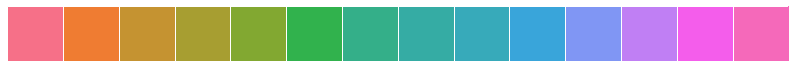

In [199]:
# plt.style.use('seaborn')
plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
sns.palplot(sns.color_palette("husl", 14))


In [200]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [222]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False, title = 'title', savefig_path = False,
                 centers= None, dists=None):

    plt.clf()
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
    palette =   sns.color_palette("husl", len(np.unique(y)))
    # Shuffle
#     plt.style.use('seaborn-bright')
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)

    # plot     
#     c = LabelEncoder().fit_transform(color_code) #encode to integers
#     c = [n*100 for n in c]
    
    data = pd.DataFrame(X_reduced, columns = ['x', 'y'])
    data['label'] = y
    color_order = np.unique(y)
    print(color_order)
#     color_order.sort()

    g = sns.lmplot(data=data, x='x', y='y', hue='label', hue_order=color_order,
                   fit_reg=False, legend=True,palette=palette, legend_out=True, scatter_kws={"s": 10})
    
#     plt.setp(g._legend.get_texts(), fontsize=20)

#     for ax in g.axes.flat:
#         plt.setp(ax.get_legend().get_texts(), fontsize=22)  # for legend text

    
#     plt.setp(facet.get_legend().get_texts(), fontsize='20')
#     scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=c, alpha=0.6, s=1,cmap='Spectral')
#     label_names = [str(n) for n in np.unique(y)] 
#     label_names.sort()
#     plt.legend(handles=scatter.legend_elements()[0], labels=label_names)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))

    # Centroids
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black',
        label='centroids')

    # LINES
    # missing one line     
    # plt.plot(centers[:,0],centers[:,1], color = 'dodgerblue', linewidth=0.5) # this works    
            
#     plt.tight_layout()    
    if title:
        plt.title(title)
    
    if savefig_path:
        print('plotting...')
        timestamp = datetime.datetime.now().isoformat()
        plt.savefig(savefig_path+title+f'_{timestamp}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [212]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True):
    
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y_encoded)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)
    
    print('running kmeans...')
    # Set k to amount of subreddits
    k = len(np.unique(y))
    # Fit kmeans
    km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
    # Obtain labels for each data point
    #     kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
#     kmeans_labels = KMeans(n_clusters = k, random_state = seed_value).fit_predict(X_reduced)
    # Obtain euclidean distance between centroids
    centers = km.cluster_centers_
    # find centroid labels      
    closest, _ = pairwise_distances_argmin_min(centers, X_reduced)
    data = pd.DataFrame(X_reduced, columns = ['x1', 'x2'])
    data['label'] = y
    centers_labels = list(data.loc[closest].label)
    
    # Plot in 2D
    if plot:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path )
            
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers)
    if method == 'metric_learning':
        return X_reduced, X_reduced_test
    else:
        return X_reduced, centers, centers_labels

def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

In [209]:

from scipy.spatial import ConvexHull


## Load data with our without subsampling

In [10]:
# subreddits = ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', 'anxiety',
#  'bipolarreddit', 'bpd',  'depression',  'healthanxiety',
#        'jokes', 'legaladvice', 'meditation', 'mentalhealth',
#        'mentalillness', 'mindfulness', 'paranoia', 
#        'personalfinance','ptsd', 'schizophrenia', 'socialanxiety', 
#        'suicidewatch']

In [11]:

def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2



# def subsample_df(df, subsample, overN):
#   if df.shape[0] > subsample_subreddits_overN:
#     subsample_int = int(df.shape[0]*subsample)
#     df = df.loc[np.random.choice(df.index,subsample_int, replace=False)]
#   return df

In [34]:
# 

def clean(df):
    # remove author duplicates and shuffle so we dont keep only first posts in time
    reddit_data = df.sample(frac=1) #shuffle
    reddit_data = reddit_data.drop_duplicates(subset='author', keep='first')
    reddit_data  = reddit_data [~reddit_data.author.str.contains('|'.join(['bot', 'BOT', 'Bot']))] # There is at least one bot per subreddit
    reddit_data = reddit_data[~reddit_data.post.str.contains('|'.join(['quote', 'QUOTE', 'Quote']))] # Remove posts in case quotes are long
    reddit_data = reddit_data.reset_index(drop=True)
    return reddit_data


def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):
    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[0]+'_{}_features.csv'.format(pre_or_post), index_col=False)        
    #     Clean
    reddit_data = clean(reddit_data)
    
    # Concat tfidf features
    reddit_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[0]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
    reddit_data = reddit_data.merge(reddit_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",

    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    if subreddits[0]=='COVID19_support' and pre_or_post == 'post':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]

    # Subsample to int or subsample float
    print(reddit_data.shape)
    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[i]+'_{}_features.csv'.format(pre_or_post), index_col=False)
        # Clean
        new_data  = clean(new_data )

        new_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[i]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
        new_data = new_data.merge(new_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",
        if subreddits[i]=='COVID19_support' and pre_or_post == 'post':
              reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data



In [35]:
# reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = 5600,pre_or_post = 'pre')

# counts = reddit_data.groupby(["subreddit", "date"]).size().reset_index(name='count')
# print('counts per day:')
# for sr in subreddits:
#   counts_d = counts[counts.subreddit == sr].mean()
#   print(sr, ': ', np.round(float(counts_d),2))

## Find optimal params (optimize on silhouette score)

In [36]:
import datetime



50 ==========================================
(7395, 351)
(50, 351)
===
addiction
(4776, 351)
(50, 351)
===
adhd
(18468, 351)
(50, 351)
===
alcoholism
(4111, 351)
(50, 351)
===
anxiety
(21930, 351)
(50, 351)
===
autism
(5136, 351)
(50, 351)
===
bipolarreddit
(3051, 351)
(50, 351)
===
bpd
(12869, 351)
(50, 351)
===
depression
(23804, 351)
(50, 351)
===
healthanxiety
(4768, 351)
(50, 351)
===
lonely
(12744, 351)
(50, 351)
===
schizophrenia
(4711, 351)
(50, 351)
===
socialanxiety
(13504, 351)
(50, 351)
===
suicidewatch
(22303, 351)
(50, 351)

0 out of 1
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely'
 'schizophrenia' 'socialanxiety' 'suicidewatch']
plotting...


<Figure size 576x396 with 0 Axes>

<Figure size 960x960 with 0 Axes>

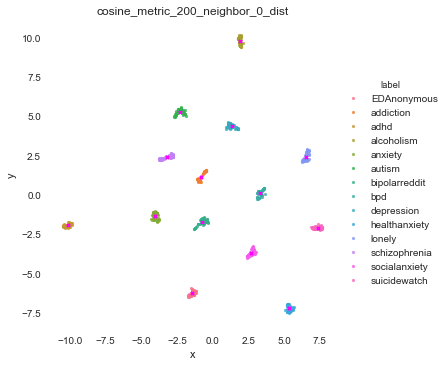

runnning metrics


In [229]:
# Plot 2D for each timestep

plot=True

repeat_n = 50
sample_sizes = [3000] * repeat_n
sample_names = [f'3000_{n}' for n in range(repeat_n)]

if toy:
    repeat_n = 2
    sample_sizes = [50] * repeat_n
    sample_names = [f'50_{n}' for n in range(repeat_n)]

#     defined through argparse
i = sample_sizes[sample]
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'

# for i, name in zip(sample_sizes, sample_names):
print('\n\n{} =========================================='.format(i))
results = {}
results_i = []
results_i_dists = []
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = i,pre_or_post = 'pre')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
X = reddit_data[features].values
y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False
annotate_names = False
run_Ntimesteps = 1# len(X)#len(X) #1,2 ... len(X) 
color_code = y.copy()


# Set up gridsearch
n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
metrics = ['cosine'] #,'cosine'] # cosine adds points?
repeat_n = 1
repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
scalers = [StandardScaler()]

gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
    print('\n{} out of {}'.format(j, len(gridsearch)))
    print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
    title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist)
    print('running umap...')         
    X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
        color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
        savefig_path = savefig_path, plot = plot)

    print('runnning metrics')
    # compute distances
    dists = euclidean_distances(centers)
    dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
    # Compute silhouette score
    sil_score = silhouette_score(X_reduced, y)

    # Compute convex hull
    hull = ConvexHull(centers)
    hull_area = hull.volume #volume is area in 2D
    results_i.append([metric,neighbor,dist,sil_score, hull_area])
    results_i_dists.append(dists_df)

results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
# results[name] = results_gs
timestamp = datetime.datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')
results_gs_dists = pd.concat(results_i_dists)
results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )

# save_obj(results,output_dir+f'umap_gs_results_{name}_{timestamp}.pkl')


        
#         # Upper triangle
#         tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
#         # Stats of upper triangle to measure overall convergence divergence
#         max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()


In [252]:
results_gs_dists

,healthanxiety,schizophrenia,depression,adhd,bipolarreddit,bpd,alcoholism,suicidewatch,socialanxiety,EDAnonymous,lonely,anxiety,autism,addiction
healthanxiety,0.000000,12.907668,12.280009,16.401695,8.217165,7.615852,17.379675,5.504943,4.437522,6.867025,9.714684,11.094215,14.673220,10.400423
schizophrenia,12.907668,0.000000,4.969205,8.168921,4.834258,6.950303,9.012414,11.493521,8.493347,8.831903,9.740779,3.838821,3.024404,2.733066
depression,12.280009,4.969205,0.000000,13.102814,6.478311,4.705526,5.464419,8.830091,8.169353,10.969798,5.534102,7.850534,3.749189,3.866958
adhd,16.401695,8.168921,13.102814,0.000000,9.391644,13.642318,16.830761,17.505913,12.970719,9.734960,17.225203,6.140290,10.659923,9.847022
bipolarreddit,8.217165,4.834258,6.478311,9.391644,0.000000,4.504999,11.868391,8.121952,3.961125,4.536108,8.390893,3.302434,7.205028,2.904610
bpd,7.615852,6.950303,4.705526,13.642318,4.504999,0.000000,9.797042,4.581306,3.848710,7.943217,3.927832,7.519335,7.648421,4.261940
alcoholism,17.379675,9.012414,5.464419,16.830761,11.868391,9.797042,0.000000,13.081502,13.511598,16.393875,8.701644,12.644055,6.182738,9.073078
suicidewatch,5.504943,11.493521,8.830091,17.505913,8.121952,4.581306,13.081502,0.000000,4.918336,9.711945,4.588685,11.416371,12.147155,8.770638
socialanxiety,4.437522,8.493347,8.169353,12.970719,3.961125,3.848710,13.511598,4.918336,0.000000,4.855970,7.197870,7.131237,10.264794,5.963370
EDAnonymous,6.867025,8.831903,10.969798,9.734960,4.536108,7.943217,16.393875,9.711945,4.855970,0.000000,11.753232,5.548797,11.559198,7.418281


In [99]:
# all_results = []
# files = os.listdir(output_dir)
# for name in sample_names:
#     filename = [n for n in files if f'_{name}_' in n][0]
# #     filename = filename.replace('/', ":")
#     results = load_obj(output_dir+filename)
#     row = [name]+list(results.get(name).iloc[-1,:].values)
#     all_results.append([
#         row
        
#     ])

# cols = ['sample']+list(results.get(name).columns)

# # results_df = pd.DataFrame(results)
# all_results = np.reshape(np.array(all_results), (6,9))
# df = pd.DataFrame(all_results, columns = cols)
# df = df.replace('cosine', 2)
# df = df.replace('euclidean', 1)  
# df[cols[1:]] = df[cols[1:]].apply(pd.to_numeric)



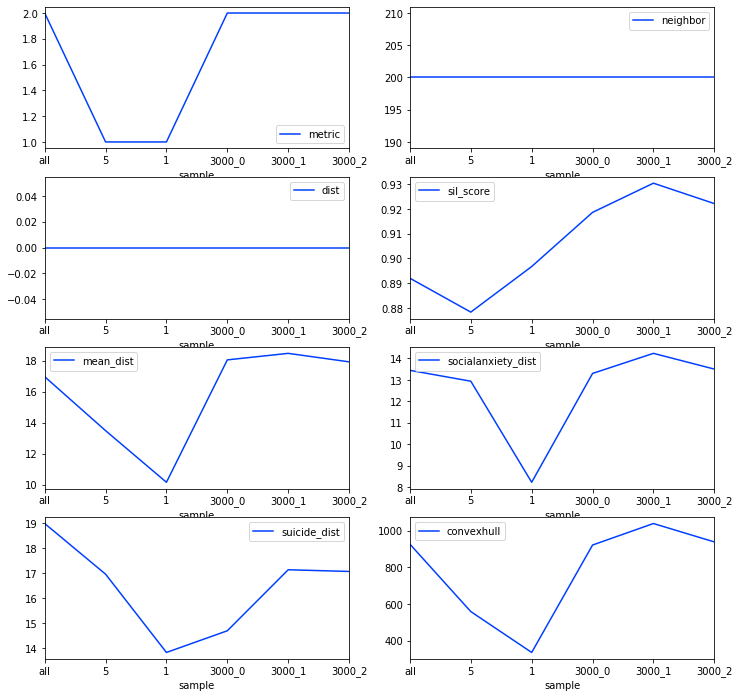

<Figure size 800x640 with 0 Axes>

In [151]:
# # fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

# fig, ax = plt.subplots(4,2, figsize=(12, 12))

# # idx = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],]

# cols_len = len(cols[1:])
# plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
# for col,i in zip(cols[1:], range(cols_len)):
#     df.plot(x="sample", y=col, kind="line", ax=ax.flat[i])
# # plt.figure(figsize=(20,20))
# fig.savefig(output_dir+'umap_gs')
    


## Build X, y by grouping data by timestep (e.g., per week)

len(days)/10

output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/output/supervised_clustering/'
timestep = 10



X = []
y = []
for i in range(0,len(days),timestep)[:-1]:
  days_week = days[i:i+timestep]
  df_week = reddit_data[reddit_data.date.isin(days_week)]
  df_week_feature_cols = df_week[features].values
  df_week_y = list(df_week.subreddit)
  X.append(df_week_feature_cols)
  y.append(df_week_y)


X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

days_week = days[::timestep]
len(days)

# Plot 2D for each timestep


method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
savefig = False
plot=True
annotate = False
annotate_names = False
run_Ntimesteps = len(X)# len(X)#len(X) #1,2 ... len(X) 


results = {}

for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
    if method  == 'metric_learning' and i==0:
        print('doing metric learning, train on first sample and test on rest')
        color_code = y[0].copy()
        continue

    print(days_week[i])
    if method == 'metric_learning':
        color_code_test = y_i.copy()
    else:
        color_code = y_i.copy()
    # groups = LabelEncoder().fit_transform(groups)
    n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [200,100]#[2,10,20,50,100,200]#   #[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0]#[0,0.1,0.25,0.5,0.8, 0.99]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics =['euclidean', 'correlation', 'cosine']# ['correlation', 'euclidean'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
        if method == 'metric_learning':
            # need to add train and test (the last arguments)             
            X_reduced, X_reduced_test = run_umap(X = X[0], y = y[0], method=method,  scaler = scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, X_test = X_i, y_test=y_i, color_code_test = color_code_test, plot = plot)
        else:    
            X_reduced, centers, centers_labels  = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric='correlation', 
                  color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=days_week[i],
                 savefig = savefig, plot = plot)
        # Measure distances             
        # TODO: add Hausdorff distance
        # TODO: add Hausdorff distance
        dists = euclidean_distances(centers)
        dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
        print(dists_df)
        # Compute silhouette score
        sil_score = silhouette_score(X_reduced, y_i)
        
        results[(days_week[i],metric,neighbor,dist)] = dists_df


        
#         # Upper triangle
#         tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
#         # Stats of upper triangle to measure overall convergence divergence
#         max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()



# save_obj(results,output_dir+'supervised_clustering_{}timestep_v3'.format(timestep) )





results = load_obj(output_dir+'supervised_clustering_{}timestep_v3'.format(timestep))
results

# plot distance between all subreddits and anxiety for 

days = np.unique([key[0] for key in results.keys()])

results_anxiety = []



print(len(items_day))  





# Make sure there is the right amount. For instance, COVID19 appears in March so if there are 9 subreddits, then there should be 9 until March when there should be 10. 
unique_index =[]
day_sr = {}
for day in days:
    items_day = [item for item in results.items() if day in item[0]]
    sr = []
    for params in items_day:
      len_index = len(params[1].index)
      len_unique_index = len(np.unique(params[1].index))
      unique_index.append(len_unique_index)
      if len_unique_index<len_index: #change depending on subreddits - COVID19 which only appears later
        continue
      sr.append(params[1]['healthanxiety'])
    day_sr[day] = sr
    
  





sr_mean = []
sr_std = []

for day in days: 
  sr = day_sr.get(day)
  sr_df = pd.concat(sr, axis=1)
  sr_mean.append(sr_df.T.mean())
  sr_std.append(sr_df.T.std())



days

sr_mean_df = pd.concat(sr_mean, axis=1)
sr_mean_df.columns=days
sr_mean_df

sr_mean_df.T.plot.line(subplots=True, figsize = (14,20))

plt.style.use('seaborn-bright')
plt.figure(figsize=(14,20), dpi= 80, facecolor='w', edgecolor='k')
for sr2 in subreddits[1:]:
  sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
  sr1_sr2_df['days'] = sr1_sr2_df.index
  sr1_sr2_df['range'] = range(len(sr1_sr2_df['days'].values))
  sns.lmplot(x='range',y=sr2,data=sr1_sr2_df,fit_reg=True, order=3) 


sr1_sr2_df

sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
sr1_sr2_df

sr1_sr2_df['days'] = sr1_sr2_df.index

sr1_sr2_df

sr1_sr2_df
sr1_sr2_df = sr1_sr2_df.reset_index()
sr1_sr2_df.columns = ['days', 'dist_to_sr1']
sr1_sr2_df

items_day

# SKIP DFS WHERE THERE IS A REPEATED COLUMN/INDEX. 

# subreddits = ['mindfulness', 'healthanxiety', 'anxiety']

# Measure distances             
dists = euclidean_distances(centers)
dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
# Upper triangle
tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
# Stats of upper triangle to measure overall convergence divergence
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
dists_df

centers

## How much do they agree?
 evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.


from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

(
    adjusted_rand_score(y_i, kmeans_labels),
    adjusted_mutual_info_score(y_i, kmeans_labels)
)

### ToDo: Can I plot distance on line?

# !pip install matplotlib-label-lines
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines

X = np.linspace(0,1,500)
A = [1,2,5,10,20]
funcs = [np.arctan,np.sin,loglaplace(4).pdf,chi2(5).pdf]

# plt.subplot(321)
for a in A:
    plt.plot(X,np.arctan(a*X),label=str(a))

labelLines(plt.gca().get_lines(),zorder=2.5)

# Plot 2D for each timestep
# https://stackoverflow.com/questions/52911890/labeling-distance-between-points-on-python-plot

# method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
# savefig = False
# plot=True
# annotate = False
# annotate_names = False
# run_Ntimesteps = 1 #len(X) 

# # for each X_i, data in each timestep:
# for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
#     if method  == 'metric_learning' and i==0:
#         print('doing metric learning, train on first sample and test on rest')
#         color_code = y[0].copy()
#         continue

#     print(days_week[i])
#     if method == 'metric_learning':
#         color_code_test = y_i.copy()
#     else:
#         color_code = y_i.copy()
#     # groups = LabelEncoder().fit_transform(groups)
#     n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
#     n_neighbors = [48]#[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
#     min_dist = [0.1]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
#     metrics = ['correlation'] # cosine adds points?
#     repeat_n = 1
#     repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
#     scalers = [StandardScaler()]

#     gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
#     for metric,neighbor,dist,dimension,scaler, r in gridsearch:
#         print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
#         if method == 'metric_learning':
#             # need to add train and test (the last arguments)             
#             plot_lines(X)
#         else:    
#             X_reduced = plot_lines(X)



# distances = []
# x_0, y_0 = a[0], b[0]
# for i in range(len(a))[:-1]:
#     if i == len(a):
#             two_points = np.array([[a[i],b[i]],
#                   [a[0],b[0]],
#                  ])
#     else:
#         two_points = np.array([[a[i],b[i]],
#                       [a[i+1],b[i+1]],
#                      ])
#     print(two_points)
#     d = euclidean_distances(two_points)
#     print(d[0][1])
#     distances.append(d[0][1])
    

    
    # Plot distance on line, couldn't solve:     

    #     import itertools
    #     combs = list(itertools.combinations(centers,4))
    #     combs = [n for i in combs for n in i]
    #     combs = np.array(combs)
    #     combs
    #     dists = euclidean_distances(combs)
    
    #     for i in range(len(a)):
    #         if i == len(a):
    #             break
    #         plt.plot(a[i:i+1], b[i:i+1])
    #     plt.text(0.9, 0.2, 'cos')


## Output gif

input_dir = '/Users/danielmlow/Dropbox (MIT)/libs/reddit/data/timestep_{}/'.format(timestep)
filenames = os.listdir(input_dir)
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)

import imageio
with imageio.get_writer(input_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)